# Calculating correlation functions

This document walks through using Py2PAC to calculate correlation functions with or without error estimates.  We'll do this with the AngularCatalog class.

First, import the things that we'll need

In [1]:
import AngularCatalog_class as ac

import numpy.random as rand
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10, 6)

--------

--------

## Creating an AngularCatalog with randomly placed data

The first catalog we'll look at will be random data- the correlation functions should be 0 at all scales.  We do this with the class method ```random_catalog``` in the ```AngularCatalog``` class.  In this case, we're just making it in a rectangle over RA = 0 to 1 degrees and Dec = -0.5 to 0.5 degrees.

In [2]:
#Set the seed
rand.seed(seed=1234)
#Generate the catalog
cat = ac.AngularCatalog.random_catalog(2e3, ra_range=[0, 1], dec_range=[-.5, .5])

Calculating the footprint of the mask
return_completenesses says: I have 2000 points that are actually on the image
ImageMask.generate_random_sample says:  We made 2000 and we need 2000.0.
return_completenesses says: I have 2000 points that are actually on the image


showing


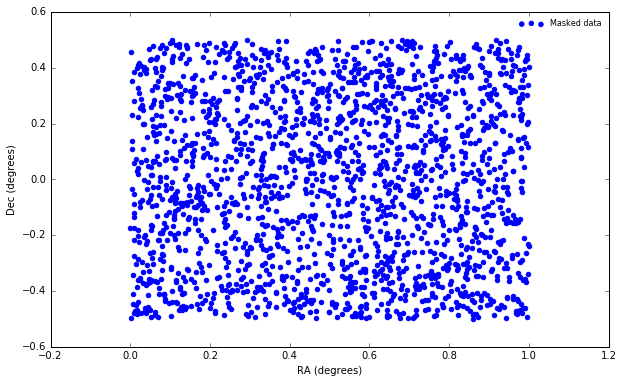

In [3]:
#Show it as a scatter plot
cat.scatterplot_points(sample="data")

--------

--------

## Calculating a correlation function

Now we want to get the correlation function from this.  The things we need are a binning in separation and a random sample.  The theta bins are set with ```AngularCatalog.set_theta_bins(min, max, nbins)``` and the randoms are generated with ```AngularCatalog.generate_random_sample(<number of randoms>)```.

### Generating randoms

The number of randoms can be defined in a few ways.   
- ```number_to_make=N```: The set number of points to lay down.
- ```multiple_of_data=N```: Makes N_data * N randoms.
- ```density_on_sky=N```: Number of randoms per square degree.

In this case, we'll just use a set number, so ```number_to_make=1e4```.

return_completenesses says: I have 10000 points that are actually on the image
ImageMask.generate_random_sample says:  We made 10000 and we need 10000.
make_randomtree says: Computing the BallTree for randoms.
showing


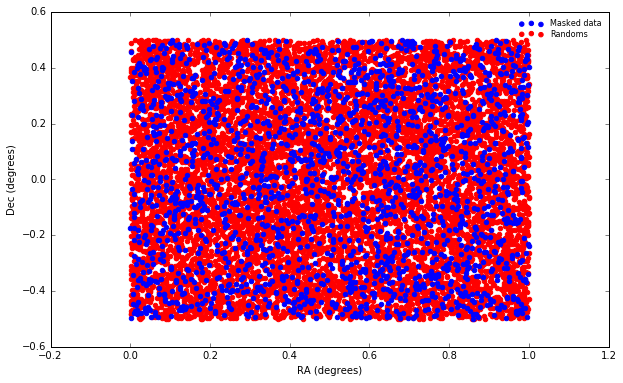

In [4]:
cat.generate_random_sample(number_to_make=1e4)
#Show it as a scatter plot
cat.scatterplot_points(sample="both")

--------

### Setting the theta binning

Pretty simple- you just use ```AngularCatalog.set_theta_bins``` and tell it the minimum and maximum separations and the number of bins and it sets it all up.  The required parameters are the min and max separation and the number of bins.  The keyword parameters are ```logbins``` and ```unit```, by default ```'a'``` and ```True``` respectively.  The ```logbins``` parameter sets whether the bins are evenly spaced in log separation (```True```) or linear separation (```False```).  The unit argument sets the unit of the input minimum and maximum separations and can be arcseconds, degrees, or radians.

In [5]:
#Set the theta bins- this has default unit='a' (for arcseconds) and logbins=True
cat.set_theta_bins(20, 1000, 10)  

#Examples of other ways you might call this
#cat.set_theta_bins(5.56e-3, 0.278, 15, unit='d')  #same as above (modulo rounding) but in deg
#cat.set_theta_bins(20, 1000, 15, logbins=False)  #Same as above but with linear bins

--------

### Different methods for calculating correlation functions

The ```AngularCatalog``` class has four functions that calculate correlation functions that differ mainly by the error estimation.  $N_{gals}$ is the total number of galaxies in the data catalogs.

1. ```AngularCatalog.cf```: calculates the correlation function without errors.
2. ```AngularCatalog.cf_bootstrap```: calculates the correlation function with errors estimated with single-galaxy bootstrapping.  What this means is that it calculates $N_{boots}$ correlation functions, each with $N_{gals}$ galaxies randomly selected from the data catalog *with replacement* so that an individual galaxy might appear several times or not at all in an interation.  The mean and standard deviation in each bin of separation are the value of and error on the correlation function at that separation.
3. ```AngularCatalog.cf_block_bootstrap```: calculates the correlation function with errors from block bootstrapping.  Block bootstrapping is like single-galaxy bootstrapping, but works with large areas of the image rather than single galaxies.  Before you run a block bootstrapped correlation function, you divide the image into $N_{blocks}$ blocks that should be as close to square and as close to equal areas as possible.  **Requires mask subdivision.**
4. ```AngularCatalog.cf_jackknife```: calculates the correlation function with errors from jackknifing.  Jackknifing is another error estimator that requires the image area to be subdivided into $N_{blocks}$ blocks.  Then, $N_{blocks}$ correlation functions are calculated, each one omitting a different spatial block.  The mean and standard deciation again estimate the correlation function value and error.  **Requires mask subdivision.**


#### Subdividing the mask

Before we do block bootstrap or jackknife, we have to subdivide the catalog.  We do this with ```AngularCatalog.subdivide_mask```.  If you want to try a subdivision method, you can use ```preview=True```, which will show you a plot of that subdivision but *will not store it*.  If you preview a subdivision and you decide you want to keep it, you must run the routine again with ```preview=False``` (the default value).

return_completenesses says: I have 50000 points that are actually on the image
ImageMask.generate_random_sample says:  We made 50000 and we need 50000.0.
bin 0 has 5606.0 randoms in it
bin 3 has 5576.0 randoms in it
bin 6 has 5472.0 randoms in it
bin 1 has 5597.0 randoms in it
bin 4 has 5539.0 randoms in it
bin 7 has 5499.0 randoms in it
bin 2 has 5536.0 randoms in it
bin 5 has 5612.0 randoms in it
bin 8 has 5563.0 randoms in it


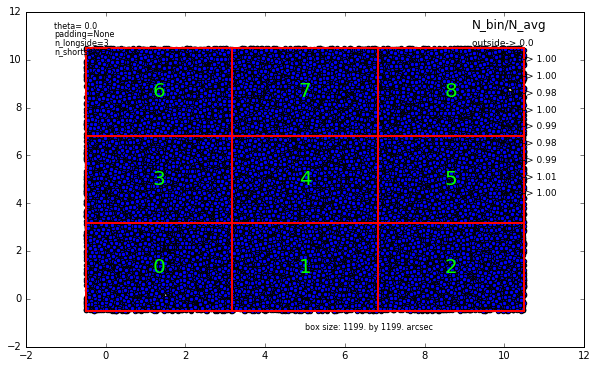

In [6]:
cat.subdivide_mask(n_shortside=3, n_longside=3, preview=True)

In [7]:
#Actually do this subdivision
cat.subdivide_mask(n_shortside=3, n_longside=3)

return_completenesses says: I have 50000 points that are actually on the image
ImageMask.generate_random_sample says:  We made 50000 and we need 50000.0.


#### Performing the calculations

Now we're set to actually calculate the correlation functions.   For more information on exactly how the individual functions work, see the documentation.

In [8]:
%%capture  
# ^ To hide the long output that we don't really care about

#Without error bars
cat.cf(n_iter=20, clobber=True, name='noerr_cf')

#Single-galaxy bootstrapping
cat.cf_bootstrap(n_boots=20, clobber=True, name="single_gal_cf")

#Block bootstrapping
cat.cf_block_bootstrap(n_boots=20, clobber=True, name="block_bs_cf")

#Jackknife
cat.cf_jackknife(clobber=True, name="jackknife")

--------

### Plotting correlation functions

The ```CorrelationFunction``` class has a plotting routine.  For convenience, the ```AngularCatalog``` class can use it to plot multiple correlation functions at once.  In general, correlation functions are plotted with a logarithmic x- and y-axis, but in this case we're plotting a correlation function that we expect to be zero.  The ```log_yscale=False``` keyword argument does this for us.

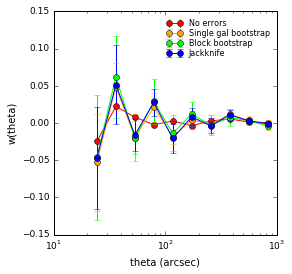

In [9]:
cat.plot_cfs(which_cfs=['noerr_cf', 'single_gal_cf', 'block_bs_cf', 'jackknife'], 
             labels=["No errors", "Single gal bootstrap", "Block bootstrap", "Jackknife"], 
             fmt='o-', log_yscale=False)

This clearly isn't exactly 0, but is generally consistent with zero.  

--------

### Correlation function management in ```AngularCatalog```s

All the correlation functions stored in an ```AngularCatalog``` object have a name that identifies them.  Each of the methods has a distinct default name, but you can also specify the name explicitly with the ```name``` keyword argument in the call to the correlation function routine.  In addition, ```AngularCatalog```s protect the already-calculated correlation functions.  If a correlation function with that name already exists in the object, you must set ```clobber=True``` in the function call in order to overwrite it.

Correlation functions are stored as ```CorrelationFunction``` objects in the ```AngularCatalog.cfs``` dictionary.  Below, we show that the ```cfs``` dictionary is empty, calculate a correlation function with no error bars with all default arguments, and then show that afterwards there is a correlation function in the dictionary with the default name for the ```cf()``` function.

In [12]:
#Simple correlation function calculation
cat.cfs={}  #Clear the correlation functions in case you're re-running this block.
print "Dictionary keys before: ", cat.cfs.keys()
print ""
cat.cf()
print "" 
print "Dictionary keys after: ", cat.cfs.keys()

Dictionary keys before:  []

CorrelationFunction.__init__ says: you did not provide any info on Gp.  Leaving it for later
CorrelationFunction.__init__ says: you gave me a valid ThetaBin object.  Storing
AngularCatalog.cf says: doing a CF calculation without error estimation

Dictionary keys after:  ['cf']


If you try to do the same thing again, it fails unless you use ```clobber=True```

In [13]:
print "Without clobber or a different name: "
cat.cf()

Without clobber or a different name: 


ValueError: AngularCatalog.cf says: There's already a CF by that name.  Please choose another or overwrite by calling with clobber=True

In [14]:
print "With clobber:"
print ""
cat.cf(clobber=True)

With clobber:

CorrelationFunction.__init__ says: you did not provide any info on Gp.  Leaving it for later
CorrelationFunction.__init__ says: you gave me a valid ThetaBin object.  Storing
AngularCatalog.cf says: doing a CF calculation without error estimation


In [ ]:
print "Without clobber but with a different name: "
print ""
cat.cf(name='cf2')
print ""
print "Correlation function names: ", cat.cfs.keys()